The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


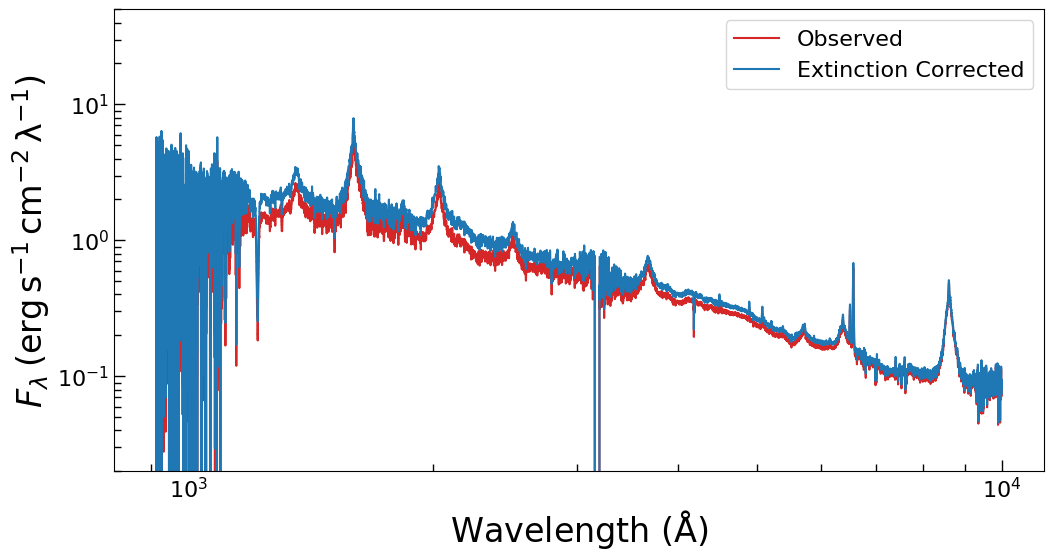

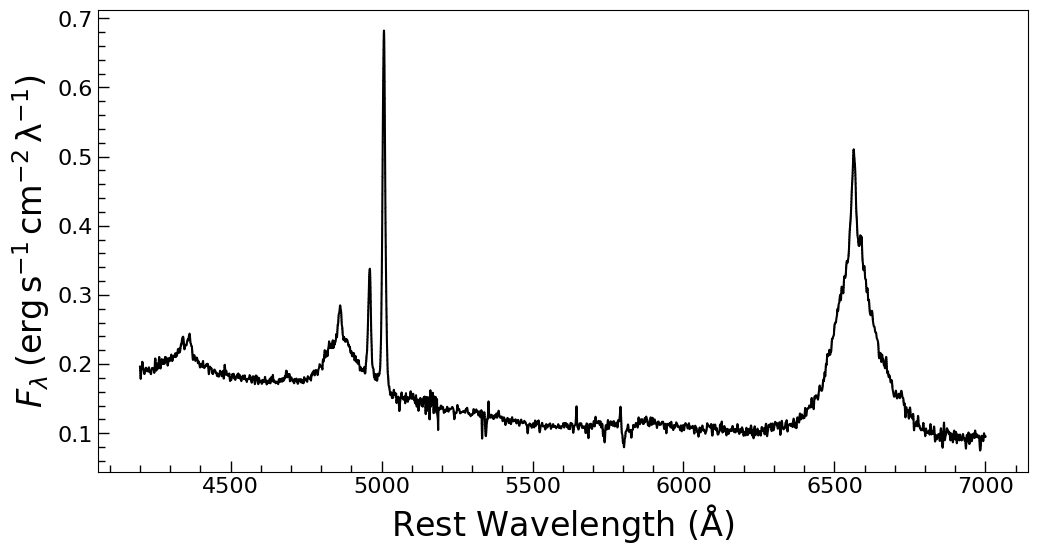

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from astropy.modeling import models, fitting
import sys
sys.path.append("../..")
import sagan

import matplotlib as mpl
mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

ls_km = 2.99792e5 # km/s
datapath = 'data'
hdul = fits.open('pg1100sed.fit')#---------------------------修改文件名
header = hdul[0].header
flux = hdul[0].data * 1e14

w0 = header['CRVAL1']
dw = header['CD1_1']
wave = w0 + dw*np.arange(flux.size)

# Find the V band attenuation from https://ned.ipac.caltech.edu/ -- FOREGROUND GALACTIC EXTINCTION
from extinction import ccm89, remove

A_V = 0.1    #------------------------------修改 消光系数
flux_dred = remove(ccm89(wave, A_V, r_v=3.1, unit='aa'), flux)

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(wave, flux, label='Observed', c='C3')
ax.step(wave, flux_dred, label='Extinction Corrected', c='C0')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.legend(fontsize=16)
ax.set_ylim(0.02, 50)#-------------------------------修改y可见范围
ax.minorticks_on()
plt.show()
zred = 0.3114 #-------------------------------------修改红移

fig, ax = plt.subplots(figsize=(12, 6))
wmin, wmax = 4200, 7000
wave_rst = wave / (1 + zred)
fltr = (wave_rst > wmin) & (wave_rst < wmax)
wave_use = wave_rst[fltr]
flux_use = flux_dred[fltr]

ax.step(wave_use, flux_use, color='k')
ax.set_xlabel(r'Rest Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.minorticks_on()
plt.show()

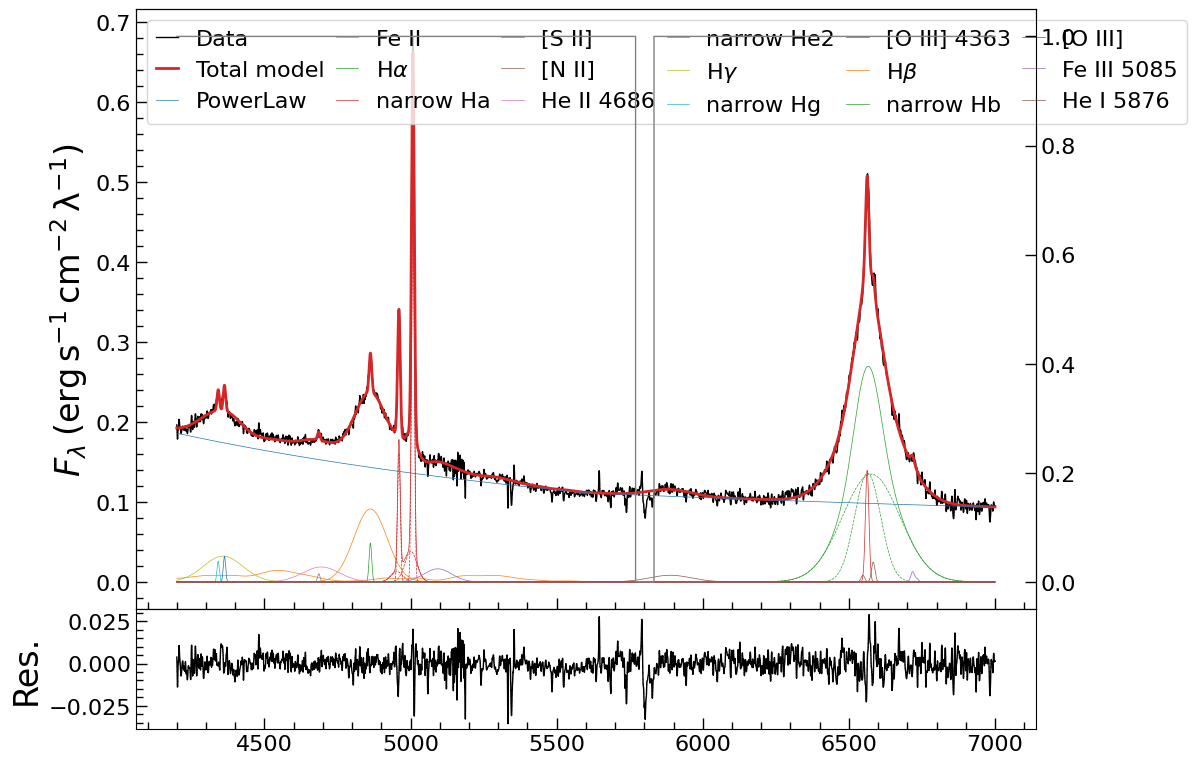

<PiecewisePowerLaw(amplitude1=0.11133, x_01=5601., alpha1=0.7919064, amplitude2=0.11133, x_02=5599., alpha2=1.78342316, name='PowerLaw')>
<IronTemplate(amplitude=0.02108555, stddev=2502.77043533, z=0., name='Fe II')>
<Line_MultiGauss(amp_c=0.13579182, dv_c=62.88661513, sigma_c=2032.79092603, wavec=6562.819, amp_w0=0.99224227, dv_w0=552.86090186, sigma_w0=4492.96871099, name='H$\\alpha$')>
<Line_Gaussian(amplitude=0.13947707, dv=-14.90428611, sigma=276.51469311, wavec=6562.819, name='narrow Ha')>
<Line_MultiGauss_doublet(amp_c0=0.01259766, amp_c1=0.00368081, dv_c=-14.90428611, sigma_c=276.51469311, wavec0=6718.29, wavec1=6732.68, name='[S II]')>
<Line_MultiGauss_doublet(amp_c0=0.02473937, amp_c1=0.0083579, dv_c=-14.90428611, sigma_c=276.51469311, wavec0=6583.46, wavec1=6548.05, name='[N II]')>
<Line_MultiGauss(amp_c=0.0186506, dv_c=500., sigma_c=4000., wavec=4686., name='He II 4686')>
<Line_Gaussian(amplitude=0.01031263, dv=-14.90428611, sigma=276.51469311, wavec=4686., name='narrow He2

In [ ]:
#------------------------------------------------------------具体拟合，修改各成分
wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict 
#pl = models.PowerLaw1D(amplitude=0.1049, x_0=5500, alpha=0.7818, fixed={'x_0': True},name='PowerLaw')
from astropy.modeling import models, fitting, Fittable1DModel, Parameter
class PiecewisePowerLaw(Fittable1DModel):
    amplitude1 = Parameter(default=0.11133,fixed=True)
    x_01 = Parameter(default=5601, fixed=True)
    alpha1 = Parameter(default=0.83108101)
    amplitude2 = Parameter(default=0.11133,fixed=True)
    x_02 = Parameter(default=5599, fixed=True)
    alpha2 = Parameter(default=1.9247682)

    @staticmethod
    def evaluate(x, amplitude1, x_01, alpha1, amplitude2, x_02, alpha2):
        pl1 = amplitude1 * (x / x_01) **(-alpha1)
        pl2 = amplitude2 * (x / x_02) ** (-alpha2)
        return np.where(x > 5600, pl1, pl2)
pl = PiecewisePowerLaw(name='PowerLaw') 

iron = sagan.IronTemplate(amplitude=0.02211901, stddev=4710.4456, z=0, name='Fe II',fixed={})

bounds = {'sigma_w0': (100, 4000)}
b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=0.135, dv_c=60, sigma_c=2060, 
                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
                             amp_w0=1, dv_w0=572, sigma_w0=4480)
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.06, dv_c=-93, sigma_c=4300, 
                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])
#b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=0.077, dv_c=-605, sigma_c=3250, 
#                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],
#                             amp_w0=0.06, dv_w0=5000, sigma_w0=4000, bounds=bounds)
b_hb = sagan.Line_MultiGauss(n_components=1, amp_c=0.09, dv_c=49, sigma_c=3515, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'])

bounds = {'sigma_c': (100, 4000), 'dv_c': (-500, 500)}
line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.0126, amp_c1=0.004,
                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]')
line_n2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.026, amp_c1=0.009, dv_c=-17, sigma_c=285,
                                        wavec0=wave_dict['NII_6583'], wavec1=wave_dict['NII_6548'], name='[N II]')
line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=0.478, amp_c1=0.16, dv_c=-15, sigma_c=280, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=0.08, dv_w0=-360, sigma_w0=1200)
#line_o3 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.5, amp_c1=0.16, dv_c=-17, sigma_c=280, 
#                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]'
#                                        )
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.035, dv_c=500, sigma_c=4000, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)
b_he1 = sagan.Line_MultiGauss(n_components=1, amp_c=0.006, dv_c=100, sigma_c=3000, wavec=5875.624, name='He I 5876')

n_ha = sagan.Line_Gaussian(amplitude=0.139, wavec=wave_dict['Halpha'], name=f'narrow Ha')
n_he2 = sagan.Line_Gaussian(amplitude=0.0076, wavec=wave_dict['HeII_4686'], name=f'narrow He2')
n_hg = sagan.Line_Gaussian(amplitude=0.032, wavec=wave_dict['Hgamma'], name=f'narrow Hg')
n_o3_4363 = sagan.Line_Gaussian(amplitude=0.039, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363')
n_hb = sagan.Line_Gaussian(amplitude=0.05, wavec=wave_dict['Hbeta'], name=f'narrow Hb')


line_ha  =  b_ha + n_ha
line_he2 =  b_he2 + n_he2
line_hg  =  b_hg + n_hg
line_hb  =  b_hb + n_hb
line_he1 =  b_he1

#b_he1_5016= sagan.Line_MultiGauss(n_components=1, amp_c=0.01, dv_c=0, sigma_c=1000,wavec=5016, name='He I 5016',bounds=bounds)
#n_fe6_5176= sagan.Line_Gaussian(amplitude=0.01, wavec=wave_dict['FeVI_5176'], name='Fe VI 5176')
b_fe3_5085= sagan.Line_MultiGauss(n_components=1, amp_c=0.013, dv_c=0, sigma_c=1000,wavec=5084.77, name='Fe III 5085',bounds=bounds)


m_init = pl+ iron+line_ha+line_s2+line_n2+line_he2+line_hg+n_o3_4363+line_hb+line_o3+b_fe3_5085+line_he1
#line_ha+line_s2+line_n2+line_he2+line_hg+n_o3_4363+line_hb+line_o3+b_fe3_5085+line_he1


# Tie the line ratio of [O III] 5007/4959 to 2.98
def tie_o3(model):
    return model['[O III]'].amp_c0 / 2.98
line_o3.amp_c1.tied = tie_o3

def tie_n2(model):
    return model['[N II]'].amp_c0 / 2.96
line_n2.amp_c1.tied = tie_n2

# Tie
def tie_narrow_sigma(model):
    return model['[O III]'].sigma_c

def tie_narrow_dv(model):
    return model['[O III]'].dv_c

line_s2.sigma_c.tied = tie_narrow_sigma
line_s2.dv_c.tied = tie_narrow_dv
line_n2.sigma_c.tied = tie_narrow_sigma
line_n2.dv_c.tied = tie_narrow_dv

for line in [n_ha, n_hb, n_hg, n_he2, n_o3_4363]:
    line.sigma.tied = tie_narrow_sigma
    line.dv.tied = tie_narrow_dv


fitter = fitting.LevMarLSQFitter()

weights = np.ones_like(flux_use)
fltr1 = (wave_use > 5770) & (wave_use < 5833)
#fltr2= (wave_use > 4237) & (wave_use < 4444)
#fltr3= (wave_use > 4928) & (wave_use < 5200)
fltr11=(wave_use > 4260) & (wave_use < 4430)
fltr12=(wave_use > 4600) & (wave_use < 5200)
fltr13=(wave_use > 5550) & (wave_use < 6050)
fltr14=(wave_use > 6200) & (wave_use < 6890)

weights[fltr1] = 0.0
#weights[fltr2] = 0.0
#weights[fltr3] = 0.0
#weights[fltr11] = 0.0
#weights[fltr12] = 0.0
#weights[fltr13] = 0.0
#weights[fltr14] = 0.0


m_fit = fitter(m_init, wave_use, flux_use, weights=weights, maxiter=10000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit, weight=weights)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
plt.show()


for m in m_fit:
    print(m.__repr__())